# Big-Data in Telecom

Authors: Suganth, Kireet, Vamsi, Bhagyashree

This notebook makes use of the Pyspark library to explore, preprocess and classify the tweets into various categories and also predict the category.

Dataset: Extracted Verizon tweets from Twitter using text search API.


In [ ]:
from pyspark import SparkConf,SparkContext
from pyspark import mllib as ml
from pyspark.ml.feature import Tokenizer,HashingTF,IDF,StopWordsRemover,CountVectorizer
from pyspark.sql import SparkSession,SQLContext,Row
from pyspark.sql.functions import lower,regexp_replace,trim
from textblob import TextBlob
import string
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType,ArrayType
import matplotlib.pyplot as plt
%matplotlib inline  
import pandas as pd

In [ ]:
#Configuring the Spark system, Master = local system.
conf = SparkConf().setMaster("local").setAppName("Project")
sc = SparkContext(conf=conf)

In [93]:
#Applying SQLContext to the Spark Context.
sqlcontext = SQLContext(sc)

In [94]:
#Starting a Spark Session
spark = SparkSession(sqlcontext)

In [95]:
#Reading the twitter data file for verizon
tweets = spark.read.csv("hdfs://quickstart.cloudera:8020/user/cloudera/final_tweets.csv",header=True)

# Data Cleaning and Preprocessing

In [96]:
## converting the tweets to lowercase
verizon_tweets=tweets.withColumn('Text',lower(tweets['Text']))

In [97]:
#remove puntuations
def punc(tweets):
    tweet = re.sub('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '',tweets)
    return tweet
udf_func = udf(punc)

In [98]:
## Removing the punctuations using user defined functions
verizon_tweets = verizon_tweets.withColumn('Text',udf_func(verizon_tweets['Text']))

In [99]:
verizon_tweets.show(2)

+---+------------+-----+--------------------+
|_c0|    Category|Label|                Text|
+---+------------+-----+--------------------+
|  0|Poor service|    4|vzwsupport give m...|
|  1|Poor service|    4|verizon my daught...|
+---+------------+-----+--------------------+
only showing top 2 rows



In [100]:
#Word Tokenization
tokenizer = Tokenizer(inputCol='Text',outputCol='words')
verizon_tweets = tokenizer.transform(verizon_tweets)

In [101]:
#Removing the stop words
stopremover= StopWordsRemover(inputCol='words',outputCol='words_nostopwords')
verizon_tweets = stopremover.transform(verizon_tweets)

In [102]:
verizon_tweets.show(3)

+---+------------+-----+--------------------+--------------------+--------------------+
|_c0|    Category|Label|                Text|               words|   words_nostopwords|
+---+------------+-----+--------------------+--------------------+--------------------+
|  0|Poor service|    4|vzwsupport give m...|[vzwsupport, give...|[vzwsupport, give...|
|  1|Poor service|    4|verizon my daught...|[verizon, my, dau...|[verizon, daughte...|
|  2|Poor service|    4|verizon  customer...|[verizon, , custo...|[verizon, , custo...|
+---+------------+-----+--------------------+--------------------+--------------------+
only showing top 3 rows



In [103]:
#Lemmatization
from nltk.stem import PorterStemmer,WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [104]:
#Bringing back the words to its root form.
def lemmas(words):
    for w in range(0,len(words)):
        words[w] = lemmatizer.lemmatize(words[w],pos='v')
        words[w] = lemmatizer.lemmatize(words[w],pos='a')
    return words

my_func1 = udf(lemmas,ArrayType(StringType()))

In [105]:
verizon_tweets = verizon_tweets.withColumn('words_nostopwords',my_func1(verizon_tweets['words_nostopwords']))

# Data Exploration

In [106]:
df1 = verizon_tweets.toPandas()

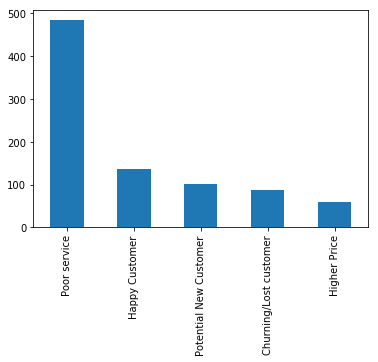

In [107]:
df1['Category'].value_counts().plot('bar')

In [108]:
df2 = verizon_tweets.groupBy('Category').count().toPandas()

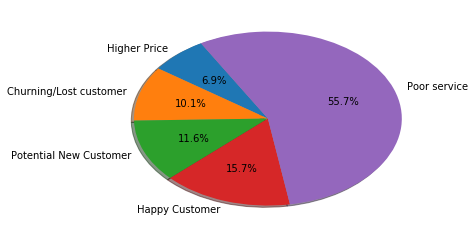

In [109]:
#Pie chart to show the split of the tweet categories for verizon
plt.pie(df2['count'], labels=df2['Category'], autopct='%1.1f%%', shadow=True, startangle=120)
plt.rcParams['figure.figsize'] = 6,5
plt.show()

In [110]:
#Word Cloud
import wordcloud
from wordcloud import WordCloud, STOPWORDS

In [111]:
replace = ['Verizon','call','tell','verizon','vzwsupport','phone','tmobile','go']

In [112]:
df1['words_nostopwords']= df1['words_nostopwords'].apply(lambda x: [item for item in x if item not in replace])

In [113]:
df1.head(4)

,_c0,Category,Label,Text,words,words_nostopwords
0,0,Poor service,4,vzwsupport give me a working phone without hav...,"[vzwsupport, give, me, a, working, phone, with...","[give, work, without, jump, hurdle, customer, ..."
1,1,Poor service,4,verizon my daughter and i both have verizon an...,"[verizon, my, daughter, and, i, both, have, ve...","[daughter, keep, fail, talk, , suggestions, ri..."
2,2,Poor service,4,verizon customer service is the worst i dread...,"[verizon, , customer, service, is, the, worst,...","[, customer, service, bad, dread, ever, contac..."
3,3,Happy Customer,2,i love having verizon i get service just about...,"[i, love, having, verizon, i, get, service, ju...","[love, get, service, anywhere, vzwnow]"


In [114]:
df1['words_nostopwords']=df1['words_nostopwords'].apply(', '.join)

In [115]:
wordcloud = WordCloud(stopwords=STOPWORDS,width=7000, height=7000
                    ).generate(' '.join(df1['words_nostopwords']))

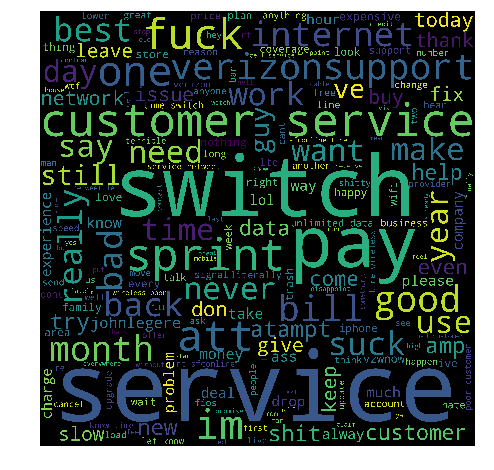

In [116]:
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Overall Sentiments of the tweets

In [117]:
#Sentiment analysis 
def sentiment_analysis(text):
    temp = TextBlob(text)
    if(temp.sentiment.polarity > 0):
        return "positive"
    elif(temp.sentiment.polarity < 0):
        return "negative"
    else:
        return "neutral"

In [118]:
Blob_udf = udf(sentiment_analysis)
verizon_tweets = verizon_tweets.withColumn('sentiment_polarity',Blob_udf(verizon_tweets['Text']))

In [119]:
df1 = verizon_tweets.toPandas()

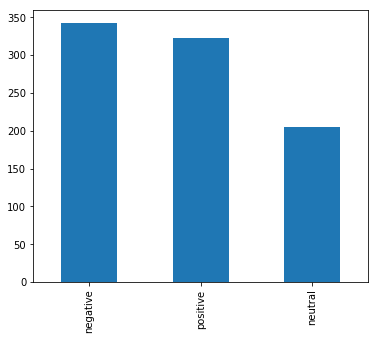

In [120]:
df1['sentiment_polarity'].value_counts().plot('bar')

# Term-Frequency and Inverse Document Frequency

In [121]:
## TF-IDF
hashingTF = HashingTF(inputCol="words_nostopwords", outputCol="rawFeatures", numFeatures=11000)
featurizedData = hashingTF.transform(verizon_tweets)


In [122]:
idf = IDF(inputCol="rawFeatures", outputCol="features")

In [123]:
idfmodel = idf.fit(featurizedData)

In [124]:
rescaled_data = idfmodel.transform(featurizedData)

# Model Building and Prediction

In [125]:
#classifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer,VectorIndexer,VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DoubleType,ArrayType,StringType

In [126]:
rescaled_data= rescaled_data.withColumn('label',rescaled_data['label'].cast(DoubleType()))

In [127]:
final_data= rescaled_data.select('label','features')

In [128]:
rf = RandomForestClassifier(featuresCol="features",labelCol="label")

In [129]:
final_data.dtypes

[('label', 'double'), ('features', 'vector')]

In [142]:
## Training and test split
(trainingData, testData) = final_data.randomSplit([0.7, 0.3])

In [143]:
## Fit the model on the training data
model = rf.fit(trainingData)

In [144]:
pred = model.transform(testData)

In [145]:
pred.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  1.0|(11000,[111,1516,...|[0.0,1.9654302924...|[0.0,0.0982715146...|       4.0|
|  1.0|(11000,[139,157,1...|[0.0,1.9654302924...|[0.0,0.0982715146...|       4.0|
|  1.0|(11000,[139,157,1...|[0.0,1.9654302924...|[0.0,0.0982715146...|       4.0|
|  1.0|(11000,[139,157,1...|[0.0,1.9654302924...|[0.0,0.0982715146...|       4.0|
|  1.0|(11000,[222,520,8...|[0.0,2.4916510573...|[0.0,0.1245825528...|       4.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



# Accuracy of the model 

In [149]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [148]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(pred)
print("Test Accuracy = %g" % (accuracy*100))

Test Accuracy = 55.814
